In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
%load_ext autoreload
%autoreload 2
from analysis import pairwise_region_comparisons
from analysis import load_data, analyze_num_units, pca_plots, rsa, stim_space_clustering
#from analysis import activity_space_clustering
from analysis import pairwise_region_comparisons, print_pairwise_results, save_pairwise_results

stim_types = ['AM', 'PT', 'NS']
periods = ['base', 'onset', 'sustained', 'offset']
regions = ['Primary auditory area',
           'Ventral auditory area',
           'Dorsal auditory area',
           'Posterior auditory area']

n_units_min = 40  # number of units from each session and brain region to subsample for analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


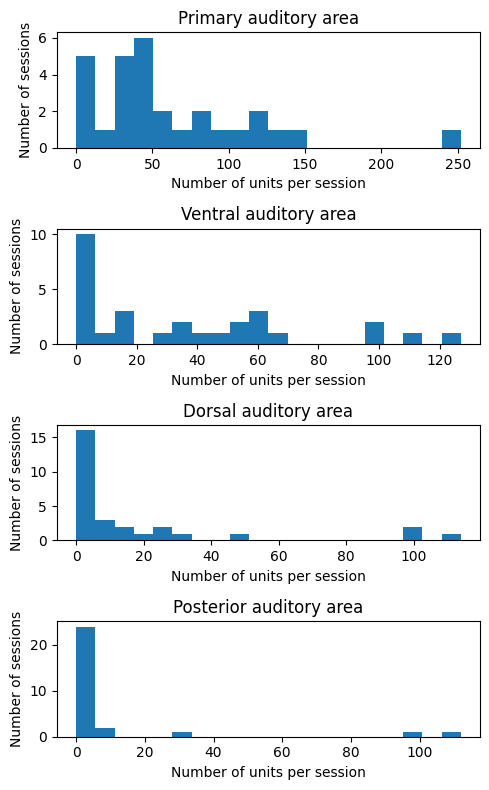

<Figure size 640x480 with 0 Axes>

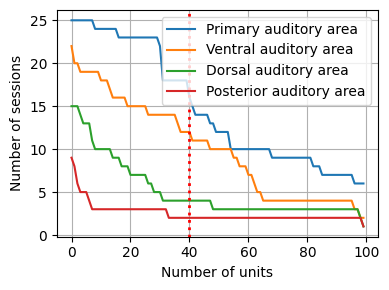

In [28]:
# Look at the numbers of units across sessions and brain areas.

data = load_data('PT')
analyze_num_units(data, n_units_min=n_units_min, save_figs=True)

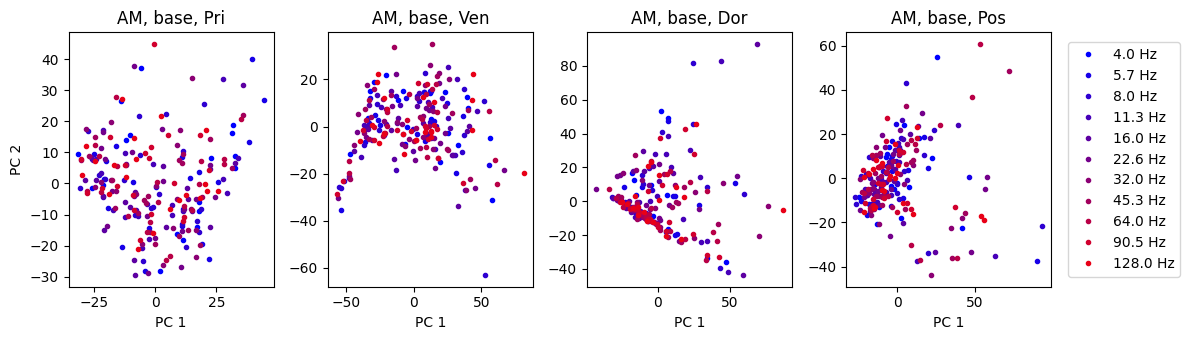

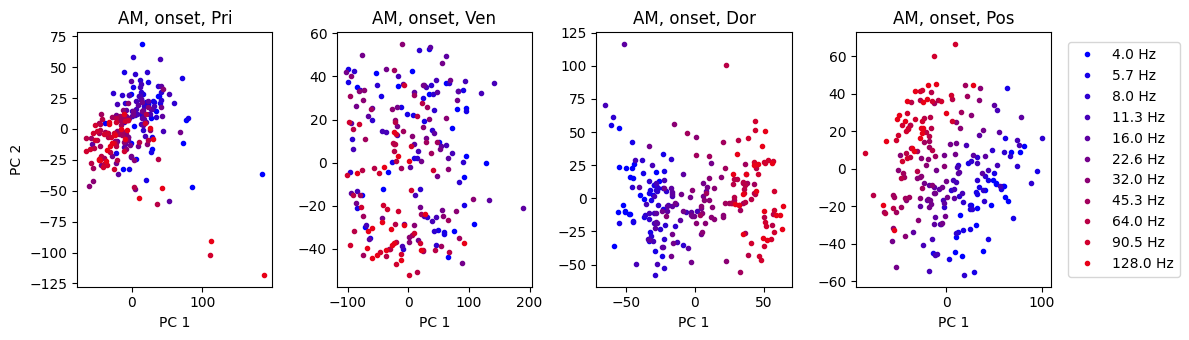

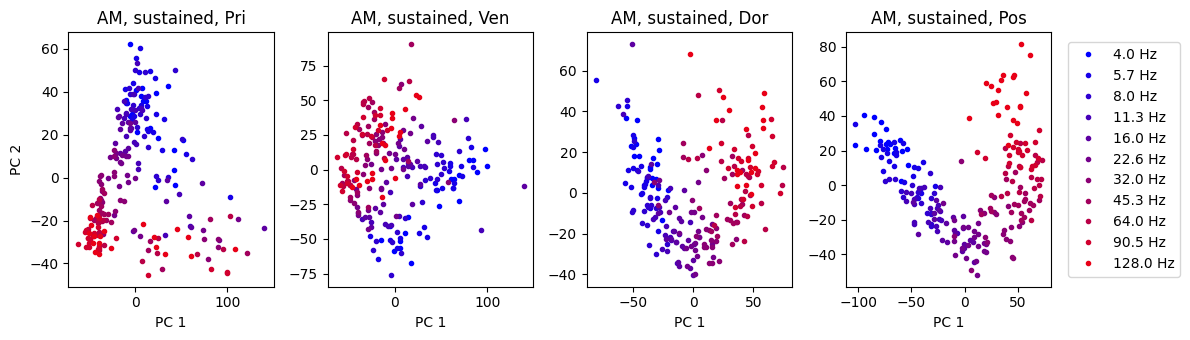

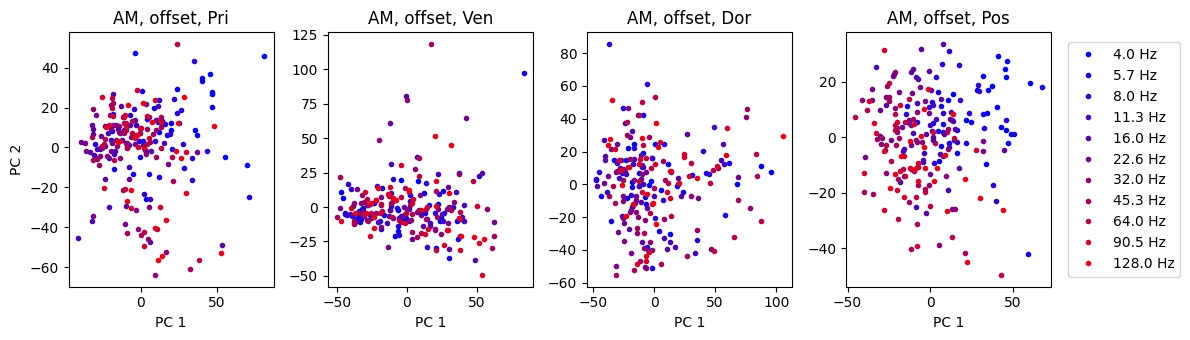

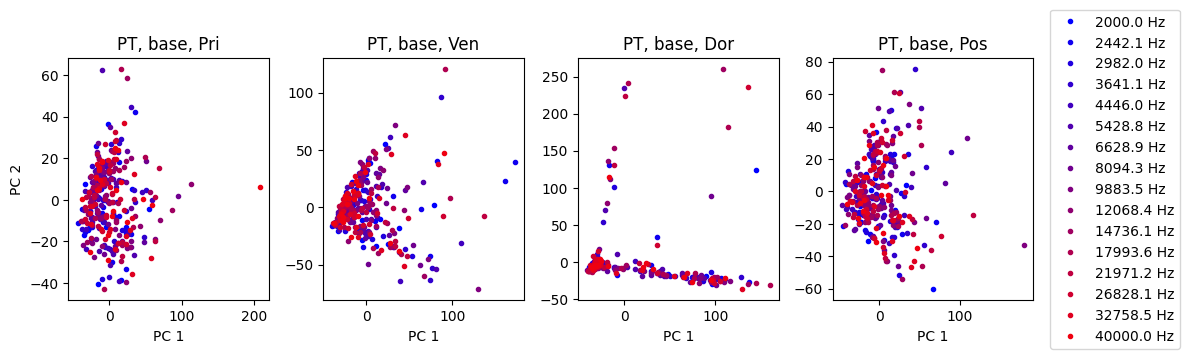

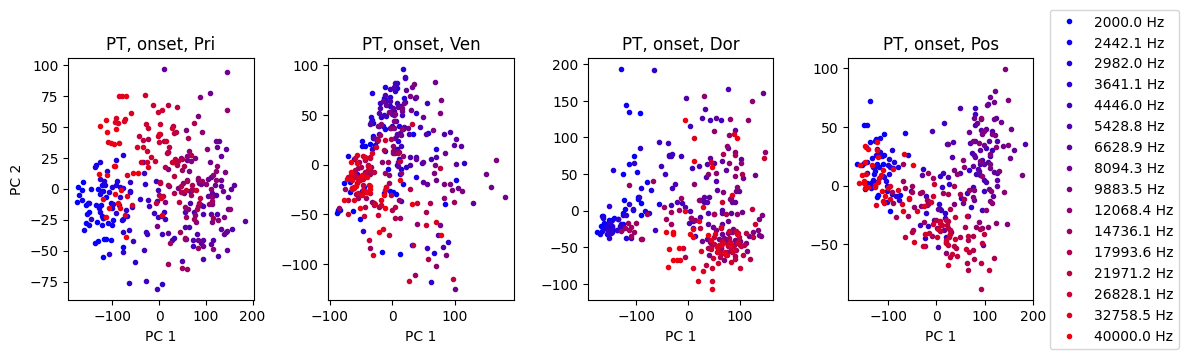

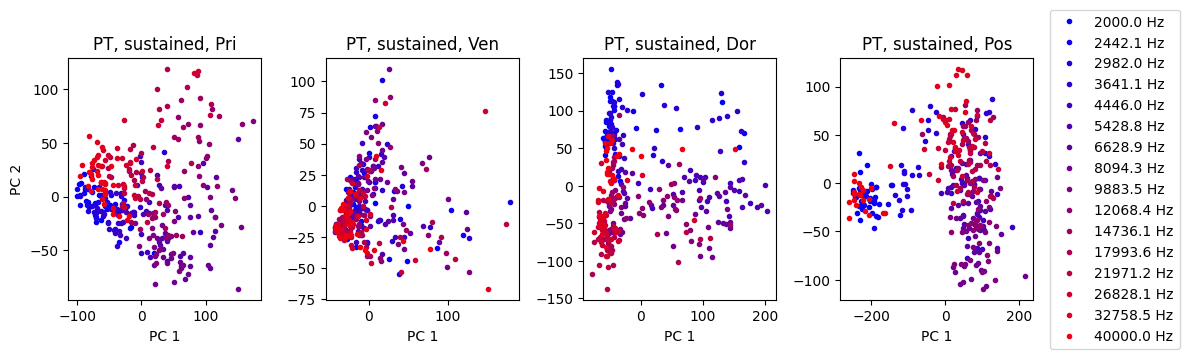

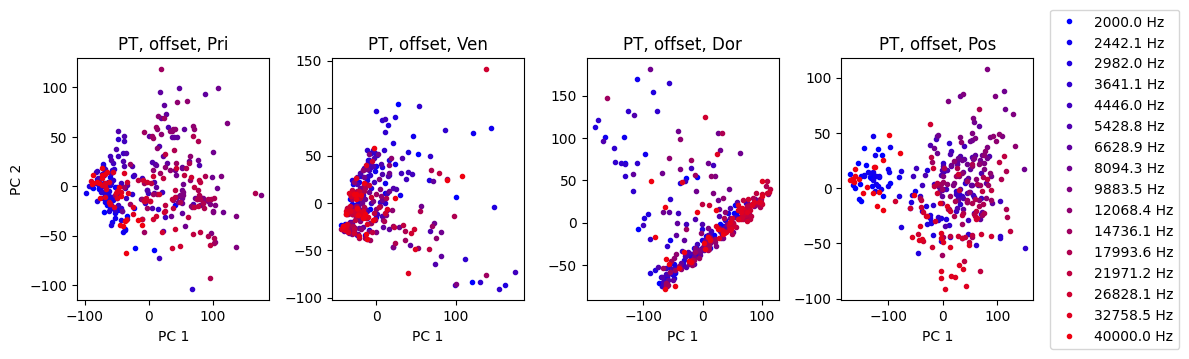

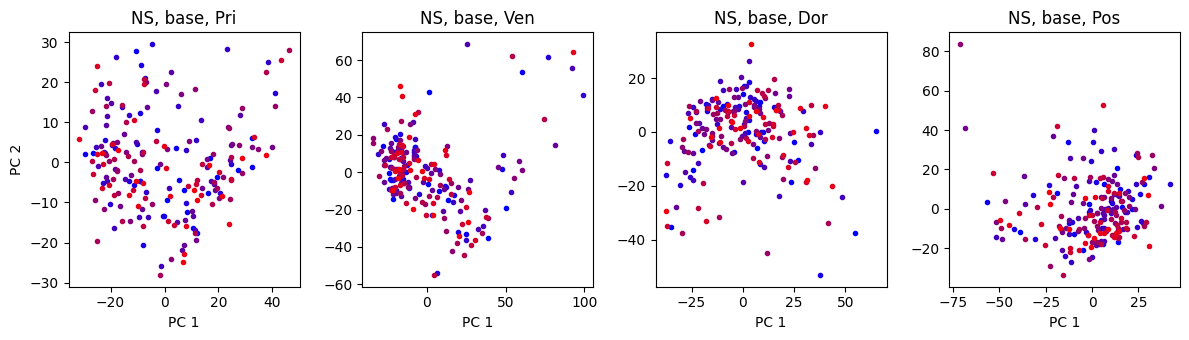

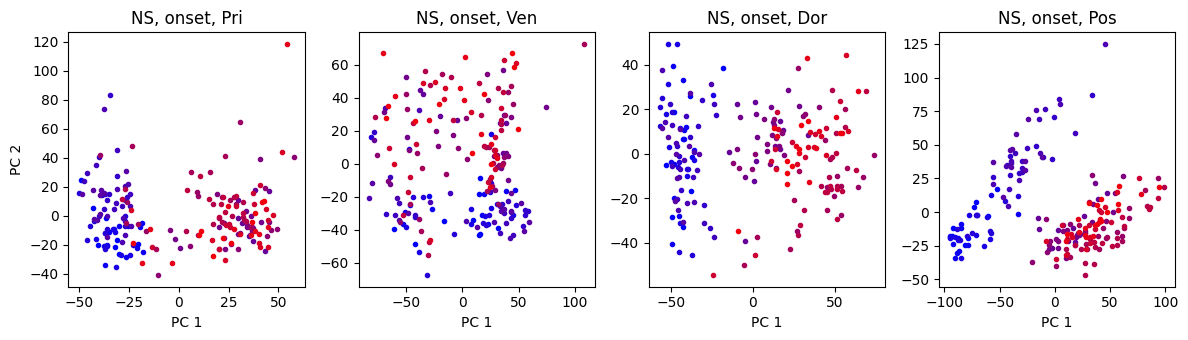

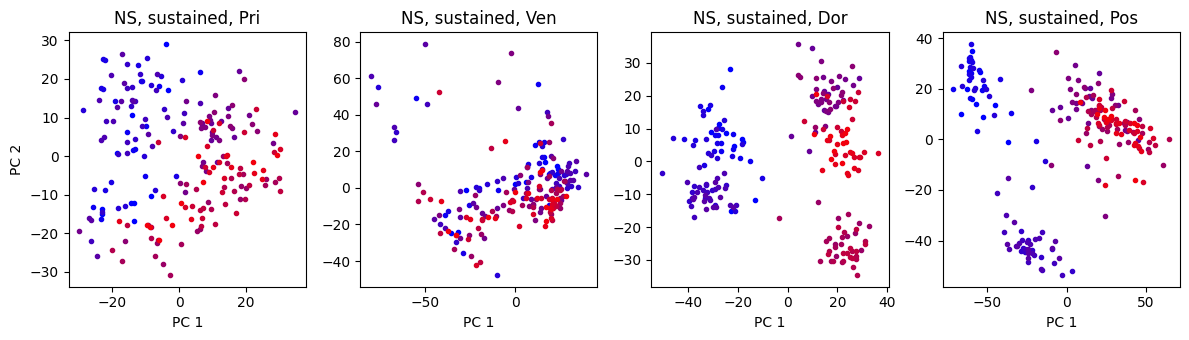

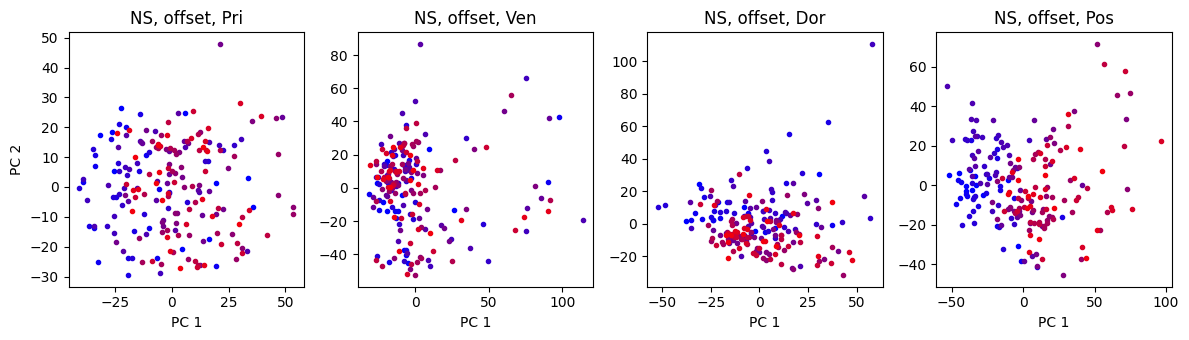

In [29]:
n_units_target = 100
pca_plots(n_units_target, savefigs=True)

In [30]:
"""'''
data : A dictionary with the following keys and values...
        - base : array of shape (n_trials, n_units) with pre-stimulus spike counts.
        - onset : array of shape (n_trials, n_units) with spike counts following stimulus onset.
        - sustained : array of shape (n_trials, n_units) with spike counts during stimulus.
        - offset : array of shape (n_trials, n_units) with spike counts following stimulus offset.
        - brainRegionArray : array of shape (n_units,) with brain regions for each unit.
        - mouseIDArray : array of shape (n_units,) with ID of mouse from which each unit was recorded.
        - sessionIDArray : array of shape (n_units,) with ID of session in which each unit was recorded.
        - stimArray : array of shape (n_trials,) with stimulus values for each trial.
'''"""

"'''\ndata : A dictionary with the following keys and values...\n        - base : array of shape (n_trials, n_units) with pre-stimulus spike counts.\n        - onset : array of shape (n_trials, n_units) with spike counts following stimulus onset.\n        - sustained : array of shape (n_trials, n_units) with spike counts during stimulus.\n        - offset : array of shape (n_trials, n_units) with spike counts following stimulus offset.\n        - brainRegionArray : array of shape (n_units,) with brain regions for each unit.\n        - mouseIDArray : array of shape (n_units,) with ID of mouse from which each unit was recorded.\n        - sessionIDArray : array of shape (n_units,) with ID of session in which each unit was recorded.\n        - stimArray : array of shape (n_trials,) with stimulus values for each trial.\n'''"

### Testing on Single Slice

In [31]:

import jax
import jax.numpy as jnp
from collections import defaultdict
print(jax.devices())

from glue_module.glue_analysis import run_glue_solver
from jaxopt import OSQP

qp = OSQP(tol=1e-4)

[CudaDevice(id=0)]


In [32]:
def get_sort_metadata(y):
    """
    Analyzes labels to create static metadata for JAX.
    """
    # Ensure CPU numpy for these calculations
    y_cpu = np.array(y)
    
    unique_labels, counts = np.unique(y_cpu, return_counts=True)
    
    if len(np.unique(counts)) > 1:
        raise ValueError(f"Labels must be balanced. Found: {dict(zip(unique_labels, counts))}")
    
    # 1. Get sort indices (groups all 0s, then all 1s, etc.)
    sort_indices = np.argsort(y_cpu, kind='stable')
    
    # 2. Return mixed dictionary (JAX arrays for data, Python ints for shapes)
    return {
        'sort_indices': jnp.array(sort_indices), 
        'n_classes': int(len(unique_labels)),
        'samples_per_class': int(counts[0]),
        'unique_labels': unique_labels
    }

In [33]:
def align_and_reshape(features, metadata):
    """
    JAX-compatible alignment using pre-computed metadata.
    
    Args:
        features (jnp.array): Shape (n_trials, n_features)
        metadata (dict): The output from get_sort_metadata
        
    Returns:
        jnp.array: Shape (n_classes, samples_per_class, n_features)
    """
    # 1. Apply the pre-calculated sort order
    # features is (n_trials, n_units), sort_indices is (n_trials,)
    # This rearranges the rows of features to match the sorted label order
    sorted_features = features[metadata['sort_indices']]
    
    # 2. Reshape
    # We use the static integers from metadata
    return sorted_features.reshape(
        metadata['n_classes'], 
        metadata['samples_per_class'], 
        -1 # Automatically handle the feature dimension
    )

In [34]:
# def align_and_reshape(features, labels):
#     """
#     Sorts and reshapes a feature array to group data by label.
    
#     Args:
#         features (np.ndarray): Input array of shape (total_samples, N_features).
#         labels (np.ndarray): Label array of shape (total_samples,).
#                              Must contain equal counts of each unique label.
    
#     Returns:
#         tuple: (grouped_features, unique_labels)
#             - grouped_features: Array of shape (n_classes, samples_per_class, N_features)
#             - unique_labels: Array of shape (n_classes,) indicating the label for each index.
#     """
#     # 1. Validate dimensions and counts
#     unique_labels, counts = np.unique(labels, return_counts=True)
    
#     if len(np.unique(counts)) > 1:
#         raise ValueError(f"Labels must be balanced. Found counts: {dict(zip(unique_labels, counts))}")
        
#     n_classes = len(unique_labels)  # This is 'a'
#     samples_per_class = counts[0]   # This is 'b'
    
#     # 2. Get sorting indices (stable sort preserves original order within groups)
#     sort_indices = np.argsort(labels, kind='stable')
    
#     # 3. Apply sorting to features
#     sorted_features = features[sort_indices]
    
#     # 4. Reshape to (a, b, N)
#     # Using -1 for the last dimension automatically handles N features
#     grouped_features = sorted_features.reshape(n_classes, samples_per_class, -1)
    
#     return grouped_features, unique_labels

# --- Example Usage ---

# # Create dummy data: a=3 classes, b=4 samples each, N=2 features
# a, b, N = 3, 4, 2
# total_samples = a * b

# # Create shuffled labels and data
# y_dummy = jnp.array([0, 1, 2] * b) # [0, 1, 2, 0, 1, 2...]
# x_dummy = jnp.arange(total_samples*N).reshape((total_samples, N))

# # Run function
# x_aligned, labels_aligned = align_and_reshape(x_dummy, y_dummy)

# print(f"Original shape: {x_dummy.shape}")      # (12, 2)
# print(f"New shape:      {x_aligned.shape}")    # (3, 4, 2)
# print(f"Mapped labels:  {labels_aligned}")     # [0 1 2]

In [37]:
# Create dummy data: a=3 classes, b=4 samples each, N=2 features
a, b, N = 3, 4, 2
total_samples = a * b

# Create shuffled labels and data
# [0, 1, 2, 0, 1, 2...]
y_dummy = jnp.array([0, 1, 2] * b) 
x_dummy = jnp.arange(total_samples * N).reshape((total_samples, N))

# --- EXECUTION ---

# Step A: Get metadata (Do this once outside your loop)
metadata = get_sort_metadata(y_dummy)

# Step B: Align and Reshape (Do this inside your vmap/loop)
x_aligned = align_and_reshape(x_dummy, metadata)

# Step C: Retrieve labels from metadata
labels_aligned = metadata['unique_labels']

# --- VERIFICATION ---
print(f"Original shape: {x_dummy.shape}")      # (12, 2)
print(f"New shape:      {x_aligned.shape}")    # (3, 4, 2)
print(f"Mapped labels:  {labels_aligned}")     # [0 1 2]

# Verify the grouping is correct (First group should be all 0s from original)
# Original x had 0, 1, 2... so indices 0, 3, 6, 9 corresponded to label 0
print("\nFirst group (Label 0) data:\n", x_aligned[0])
# print(x_dummy)
# print(x_aligned)

Original shape: (12, 2)
New shape:      (3, 4, 2)
Mapped labels:  [0 1 2]

First group (Label 0) data:
 [[ 0  1]
 [ 6  7]
 [12 13]
 [18 19]]


In [42]:
def run_glue_analysis(x_reshaped, key, qp):
    '''x_reshaped has shape: (P,M,N)'''
    new_key, next_key = jax.random.split(key)
    P = x_reshaped.shape[0]
    M = x_reshaped.shape[1]
    N = x_reshaped.shape[2]
    n_t = 200 # chou2025a uses n_t = 200
    geometries, _ = run_glue_solver(new_key, x_reshaped, P, M, N, n_t, qp)
    return geometries, next_key

In [44]:
# test GLUE on a single slice of data
sessionIDs = list(set(load_data('PT')['sessionIDArray']))
session = '2024-06-13'
stim_type = 'AM'
region = 'Primary auditory area'
period = 'base'
data_s = load_data(stim_type)
session_mask = data['sessionIDArray'] == session
region_mask = data['brainRegionArray'] == region
units_mask = np.logical_and(session_mask, region_mask)
x_slice = jnp.array(data[period])
y_slice = data['stimArray']

key = jax.random.PRNGKey(43)
# a. Randomly select units
metadata = get_sort_metadata(y_slice)
# (Note: You need to generate indices, let's assume you have a key)
indices = jax.random.choice(key, x_slice.shape[1], shape=(n_units_min,), replace=False)

# b. Slice the data
x_subsampled = x_slice[:, indices]

# c. Align and Reshape (The new fast function)
# realigned_x shape: (n_classes, samples_per_class, n_units_min)
realigned_x = align_and_reshape(x_subsampled, metadata)

# d. Run analysis
# Ensure run_glue_analysis is JAX compatible!
# geoms, _ = run_glue_analysis(realigned_x, key, qp)
# select_units = np.random.choice(np.where(units_mask)[0], size=n_units_min, replace=False)
# x_slice_subsample = x_slice[:, select_units]
# realigned_x, _ = align_and_reshape(x_slice_subsample, y_slice)
g_key = jax.random.PRNGKey(90)
geometries, g_key = run_glue_analysis(realigned_x, g_key, qp)


In [45]:
geometries

(Array(0.5097495, dtype=float32),
 Array(1.2961929, dtype=float32),
 Array(1.2553337, dtype=float32),
 Array(0.9254117, dtype=float32),
 Array(0.08772216, dtype=float32),
 Array(0.14742477, dtype=float32),
 Array(1.2610569, dtype=float32))

In [ ]:
# Compute some metric for all sessions, stimulus types, brain regions, and time periods.
metric_avg = defaultdict(list)

g_key = jax.random.PRNGKey(41)
n_subsample_repeats = 100
sessionIDs = list(set(load_data('PT')['sessionIDArray']))
for session in sessionIDs:
    print(f'Processing session {session}...')
    for stim_type in stim_types:
        data = load_data(stim_type)
        for region in regions:
            session_mask = data['sessionIDArray'] == session
            region_mask = data['brainRegionArray'] == region
            units_mask = np.logical_and(session_mask, region_mask)
            n_units = np.sum(units_mask)
            if n_units >= n_units_min:
                for period in periods:
                    x = data[period] # n_trials by n_units
                    y = data['stimArray'] # n_trials
                    # print(set(y))
                    metrics = np.zeros((n_subsample_repeats,7)) # geometries order: capcity, dim, radius, center_align, axis_align, cen_axis_align, approx_capacity
                    for k in range(n_subsample_repeats):
                        selected_units = np.random.choice(np.where(units_mask)[0], size=n_units_min, replace=False)
                        x_subsampled = x[:, selected_units] # n_trials x selected_units (40)
                        realigned_x, _ = align_and_reshape(x_subsampled, y)
                        geometries, g_key = run_glue_analysis(realigned_x, g_key, qp)
                        # print(realigned_x.shape)
                        metrics[k, :] = np.array(geometries)
                    metric_avg[(session, stim_type, region, period)].append(np.mean(metrics, axis=0))


Processing session 2024-03-22...
Processing session 2024-03-27...
Processing session 2024-06-11...
Processing session 2024-03-19...


KeyboardInterrupt: 

In [ ]:
import pickle

# 1. Save the dictionary to a file
def save_dict(dictionary, filename):
    with open(filename, 'wb') as f:  # 'wb' is strictly required (write binary)
        pickle.dump(dictionary, f)
    print(f"Dictionary saved to {filename}")

# 2. Load the dictionary back
def load_dict(filename):
    with open(filename, 'rb') as f:  # 'rb' is strictly required (read binary)
        return pickle.load(f)
    
save_dict(metric_avg, './ave_geometries_auditory_data_dict.pkl')

49


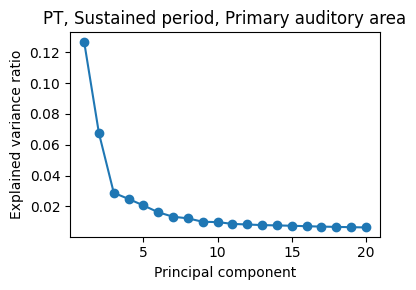

In [ ]:
# Make a PCA plot for one session, stimulus type, brain region, and time period.

sessionIDs = list(set(load_data('PT')['sessionIDArray']))

session = sessionIDs[0]
stim_type = 'PT'
region = 'Primary auditory area'
period = 'sustained'
data = load_data(stim_type)

session_mask = data['sessionIDArray'] == session
region_mask = data['brainRegionArray'] == region
units_mask = np.logical_and(session_mask, region_mask)
n_units = np.sum(units_mask)
if n_units >= n_units_min:
    print(n_units)
    x = data[period] # n_trials by n_units
    y = data['stimArray'] # n_trials

from sklearn.decomposition import PCA

# Example data: 200 samples, 20 features
rng = np.random.default_rng(0)
X = rng.normal(size=(200, 20))

# Fit PCA with all components
pca = PCA(n_components=min(X.shape))
pca.fit(x)

var = pca.explained_variance_ratio_
cum = np.cumsum(var)

plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, len(var) + 1), var, marker="o", label="Variance explained")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title('PT, Sustained period, Primary auditory area')
plt.tight_layout()
plt.show()